# Megaline Plan Recommendation
## Aaron Witt

## Introduction:

It has been discovered that there is a high amount of Megaline customers using legacy plans. By analyzing subscribers' behavior in terms of usage we will recommend one of Megaline's newer plans: Smart or Ultra. We have a dataset providing us with subscriber's call counts, total minutes used, total messages sent, total mb of data used and whether the subscriber has the Ultra or Smart plan. We'll perform data preprocessing, exploratory analysis, model training, and evaluation to determine which plan best suits a given user based on usage features.

The dataset contains 3.214 entries with the following columns:  
-calls: Number of voice calls made per user  
-minutes:  Total minutes spent on calls per user  
-messages: Number of text messages sent  
-mb_used: Mobile internet data used (in megabytes)  
-is_ultra: Target variable (1 for Ultra plan, 0 for Smart plan)

In [10]:
# Import libraries and dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('users_behavior.csv')
print('Dataset Information:\n\n',df.head(),'\n')
print(df.info(),'\n')
print('Class Distribution: \n', df['is_ultra'].value_counts())

Dataset Information:

    calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None 

Class Distribution: 
 is_ultra
0    2229
1     985
Name: count, dtype: int64


We will take note of the higher representation found for users of the Smart plan compared to Ultra.

In [11]:

# Split the source data into a training set, a validation set, and a test set.
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']
# Seperate test data
features_train_values, features_test, target_train_values, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
# Seperate training and validation data
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_values, target_train_values, test_size=0.25, random_state=12345)


In order to achieve a model with the highest possible accuracy, we will use a random forest.  However, to create a quick baseline we will create a decision tree model and tune it's hyperparameters.

In [12]:
best_model = None
best_result = 0
best_depth = 0

for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)  # corrected variable name
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

print("Accuracy of the best model:", best_result)
print("Model Depth:", best_depth)

Accuracy of the best model: 0.7744945567651633
Model Depth: 7


In [13]:
best_model = None
best_result = 0

for splits in range(2, 10):
    for leafs in range(1,10):
        model = DecisionTreeClassifier(random_state=12345, max_depth=7, min_samples_split=splits, min_samples_leaf=leafs)
        model.fit(features_train, target_train)  # corrected variable name
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        if result > best_result:
            best_model = model
            best_result = result
            num_leafs = leafs
            num_splits = splits

print("Accuracy of the best model:", best_result)
print("\nNumber of leaves: ", num_leafs, "\nNumber of splits: ", num_splits)

Accuracy of the best model: 0.7916018662519441

Number of leaves:  8 
Number of splits:  2


In [14]:
model = DecisionTreeClassifier(random_state=12345, max_depth=7, min_samples_split=2, min_samples_leaf=8)
model.fit(features_train, target_train)  # corrected variable name
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)

print("Accuracy of the best decision tree model:", best_result)

Accuracy of the best decision tree model: 0.7916018662519441


In [15]:
#Create random forest model
rf_model = RandomForestClassifier(random_state=12345)
rf_model.fit(features_train, target_train)
accuracy_rf = rf_model.score(features_valid, target_valid)
print('Validation accuracy (random forest): ', accuracy_rf)

Validation accuracy (random forest):  0.7947122861586314


As expected we see an increase in accuracy with our random forest model.  The added training and testing time of generating a random forest will help us in our goal of achieving the highest possible accuracy.  Next, we will tune the parameters.

In [16]:

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(100, 200, 5):
    for depth in range (10, 20, 5):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("Accuracy of the best model on the validation set:", best_result,
      "n_estimators:", best_est, "best_depth:", best_depth)

Accuracy of the best model on the validation set: 0.7993779160186625 n_estimators: 100 best_depth: 15


We will zoom in around these n_estimator and depth values to try to get an even higher accuracy:

In [17]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(105, 110):
    for depth in range (10,15):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("Accuracy of the best model on the validation set:", best_result,
      "n_estimators:", best_est, "best_depth:", best_depth)

Accuracy of the best model on the validation set: 0.80248833592535 n_estimators: 108 best_depth: 12


We have found the best values for n_estimators and depth.

In [18]:
model = RandomForestClassifier(n_estimators=108, max_depth=12, random_state=12345)
model.fit(features_train_values, target_train_values)
test_predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, test_predictions)
print('Test Accuracy: ', accuracy)

Test Accuracy:  0.7978227060653188


In [19]:
print(classification_report(target_test, test_predictions))
print('\nConfusion Matrix:')
print(confusion_matrix(target_test, test_predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       447
           1       0.73      0.54      0.62       196

    accuracy                           0.80       643
   macro avg       0.77      0.72      0.74       643
weighted avg       0.79      0.80      0.79       643


Confusion Matrix:
[[408  39]
 [ 91 105]]


Here we can see the model performs strongly at recommending the Smart class.  The highest concern would be that the model only finds 54% (91 False Negatives) of Ultra users - potentially under-recommending the premium plan.

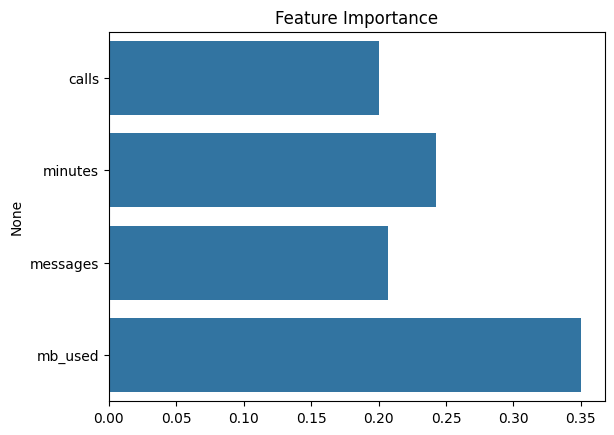

In [20]:
importances = model.feature_importances_
feature_names = features.columns
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()

We see that mb_used contributed the most to the model's decisions, while the amount of messages sent contributed the least.  Users with higher MB consumption are the most likely to be matched with the Ultra plan.

## Conclusion

We have selected the final model with n_estimators=108 and max_depth=12, based on validation accuracy of 0.802. When tested on the unseen data, the model achieved 0.798 accuracy, confirming stable generalization and meeting the project threshold of 0.75.

We see that mb_used contributed the most to the model's decisions, while the amount of messages sent contributed the least.  Users with higher MB consumption are the most likely to be matched with the Ultra plan.

Finally, while this model is highly tuned for accuracy, we can see in the confusion matrix the highest percentage of concern for misclassification would be for higher usage users being recommended the Smart plan when they should have been recommended the Ultra plan.  While this misclassification can lead to user overages, we see much less error in terms of recommending the higher tier subscription to low-usage users.